In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from src.config import load_config
from src.logger import logger
from src.data import Fred_Data
config = load_config()
fred_data = Fred_Data(api_key=fred_api_key,series_ids=config['series_ids'])
fred_data = fred_data.fetch_data()
df = fred_data.get_dataframe()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


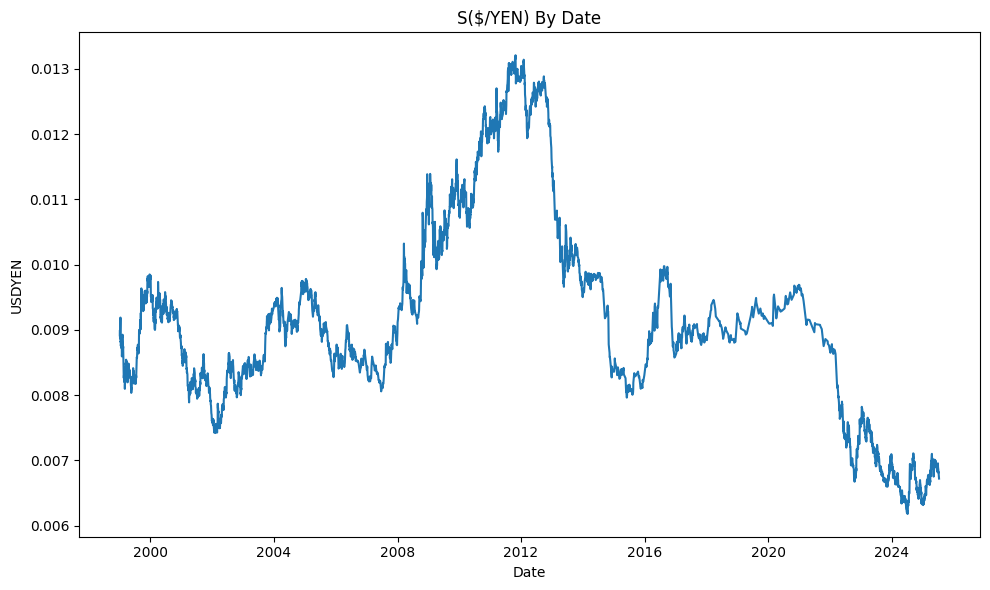

In [2]:
# changing the S(YEN/USD) to a direct quote

df['USDYEN'] = 1 / df['YENUSD']
df = df['USDYEN']
df.drop_duplicates(inplace=True)


df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDYEN',data=df)
plt.title("S($/YEN) By Date")
plt.savefig("images/spotrate-USDYEN.png")
plt.tight_layout()
plt.show()




In [3]:

training = df.iloc[:,0:1].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length - 1):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 64
num_layers = 2
num_layers = 1
output_size = 1


model = GRU(input_size,hidden_size,num_layers,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')




C:\Users\katsa\AppData\Local\Temp\ipykernel_3380\2902783951.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_3380\2902783951.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.584; Test RSME: 0.08774
Epoch: 1; train_RSEM: 0.5621; Test RSME: 0.07057
Epoch: 2; train_RSEM: 0.5403; Test RSME: 0.05462
Epoch: 3; train_RSEM: 0.5185; Test RSME: 0.04157
Epoch: 4; train_RSEM: 0.4968; Test RSME: 0.03517
Epoch: 5; train_RSEM: 0.4749; Test RSME: 0.03926
Epoch: 6; train_RSEM: 0.453; Test RSME: 0.05177
Epoch: 7; train_RSEM: 0.431; Test RSME: 0.06859
Epoch: 8; train_RSEM: 0.4089; Test RSME: 0.08759
Epoch: 9; train_RSEM: 0.3867; Test RSME: 0.108
Epoch: 10; train_RSEM: 0.3643; Test RSME: 0.1294
Epoch: 11; train_RSEM: 0.3419; Test RSME: 0.1518
Epoch: 12; train_RSEM: 0.3195; Test RSME: 0.1751
Epoch: 13; train_RSEM: 0.2975; Test RSME: 0.1993
Epoch: 14; train_RSEM: 0.276; Test RSME: 0.2243
Epoch: 15; train_RSEM: 0.2557; Test RSME: 0.2503
Epoch: 16; train_RSEM: 0.2373; Test RSME: 0.277
Epoch: 17; train_RSEM: 0.2216; Test RSME: 0.3042
Epoch: 18; train_RSEM: 0.2098; Test RSME: 0.3318
Epoch: 19; train_RSEM: 0.2029; Test RSME: 0.3591
Epoch: 20; train_RSEM: 0.20

In [4]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length: -1]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

         Date  Actual Spot Rate  Predicted Spot Rate
0  2023-10-20          0.006673             0.006747
1  2023-10-23          0.006676             0.006741
2  2023-10-24          0.006674             0.006739
3  2023-10-25          0.006669             0.006738
4  2023-10-26          0.006647             0.006737
5  2023-10-27          0.006684             0.006732
6  2023-10-30          0.006711             0.006733
7  2023-10-31          0.006602             0.006739
8  2023-11-01          0.006624             0.006731
9  2023-11-02          0.006645             0.006722
10 2023-11-03          0.006695             0.006716
11 2023-11-07          0.006646             0.006719
12 2023-11-08          0.006633             0.006719
13 2023-11-09          0.006621             0.006715
14 2023-11-13          0.006598             0.006708
15 2023-11-14          0.006633             0.006702
16 2023-11-15          0.006619             0.006699
17 2023-11-16          0.006641             0.

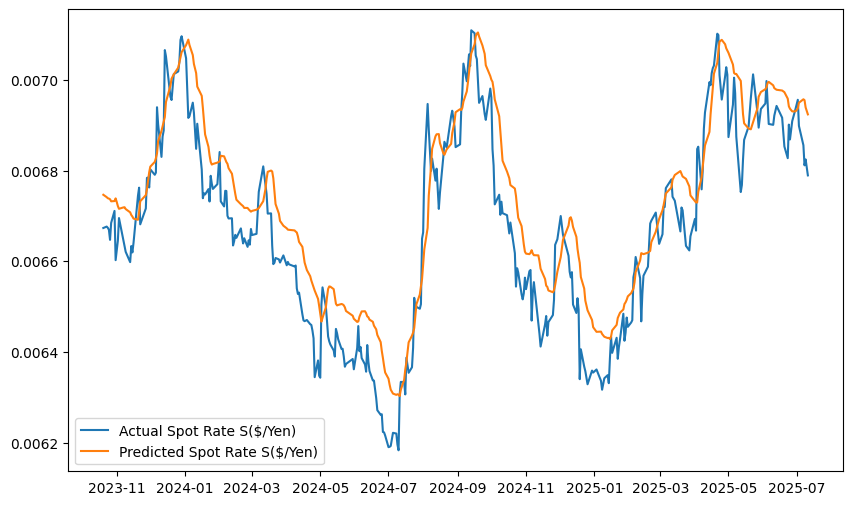

In [5]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/Yen)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/Yen)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate-usdyen.png")
plt.show()